In [1]:
import re
import glob
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 10
plt.rcParams['figure.figsize'] = (12, 6)

We'll use the same dataset of beer reviews.

In [2]:
df = pd.read_csv('data/beer_subset.csv.gz', parse_dates=['time'], compression='gzip')
review_cols = ['review_appearance', 'review_aroma', 'review_overall',
               'review_palate', 'review_taste']
df.head()

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
0,7.0,2511,287,Bell's Cherry Stout,American Stout,4.5,4,4.5,4.0,blaheath,4.5,Batch 8144\tPitch black in color with a 1/2 f...,2009-10-05 21:31:48
1,5.7,19736,9790,Duck-Rabbit Porter,American Porter,4.5,4,4.5,4.0,GJ40,4.0,Sampled from a 12oz bottle in a standard pint...,2009-10-05 21:32:09
2,4.8,11098,3182,Fürstenberg Premium Pilsener,German Pilsener,4.0,3,3.0,3.0,biegaman,3.5,Haystack yellow with an energetic group of bu...,2009-10-05 21:32:13
3,9.5,28577,3818,Unearthly (Imperial India Pale Ale),American Double / Imperial IPA,4.0,4,4.0,4.0,nick76,4.0,"The aroma has pine, wood, citrus, caramel, an...",2009-10-05 21:32:37
4,5.8,398,119,Wolaver's Pale Ale,American Pale Ale (APA),4.0,3,4.0,3.5,champ103,3.0,A: Pours a slightly hazy golden/orange color....,2009-10-05 21:33:14


In [3]:
df.beer_id.nunique()

13014

In [4]:
df.profile_name.nunique()

5990

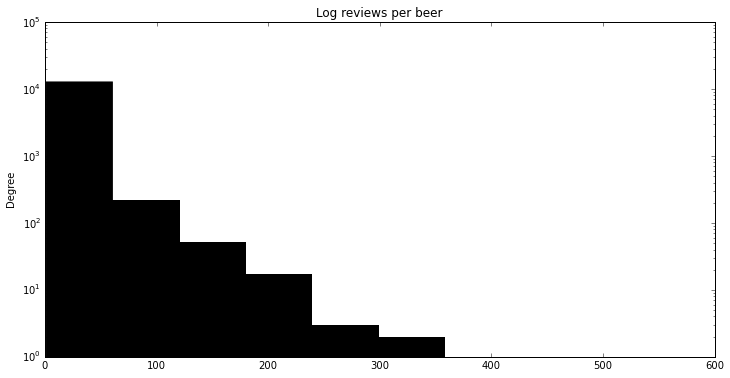

In [5]:
df.beer_id.value_counts().plot(kind='hist', bins=10, color='k', log=True,
                               title='Log reviews per beer');

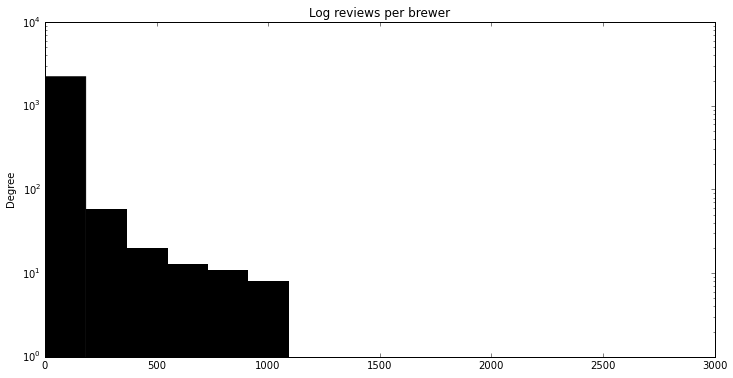

In [6]:
ax = df.brewer_id.value_counts().plot(kind='hist', bins=15, color='k', log=True,
                                      title='Log reviews per brewer');

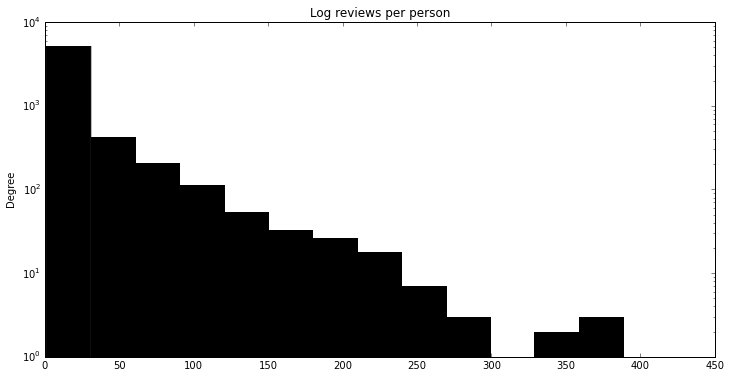

In [7]:
df.profile_name.value_counts().plot(kind='hist', bins=15, color='k', log=True,
                                    title='Log reviews per person');

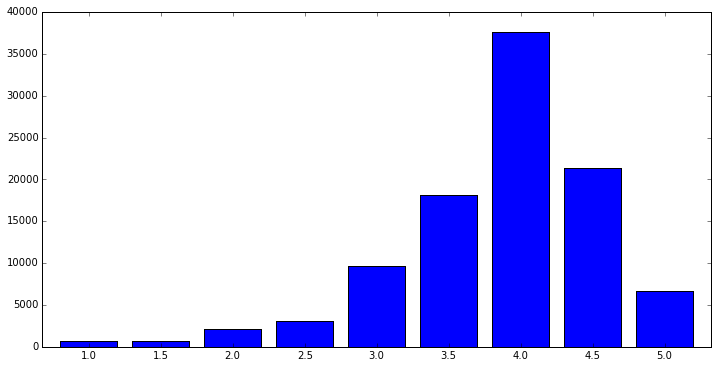

In [8]:
df.review_overall.value_counts().sort_index().plot(kind='bar', width=.8, rot=0);

NameError: name 'sns' is not defined

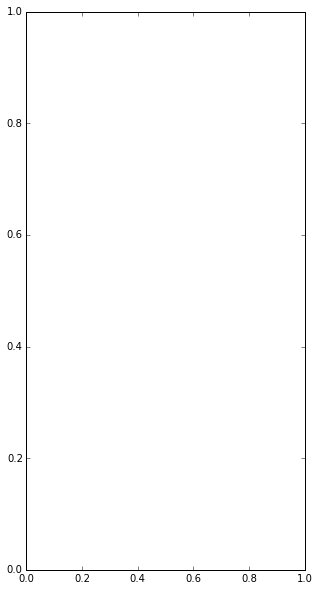

In [10]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.countplot(hue='kind', y='stars', data=(df[review_cols]
                                           .stack()
                                           .reset_index(level=1)
                                           .rename(columns={'level_1': 'kind',
                                                            0: 'stars',})),
              ax=ax, order=np.arange(0, 5.5, .5));

# Groupby

Groupby is a fundamental operation to pandas and data analysis.

The components of a groupby operation are to

1. Split a table into groups
2. Apply a function to each groups
3. Combine the results

In pandas the first step looks like

```python
df.groupby( grouper )
```

`grouper` can be many things

- Series (or string indicating a column in `df`)
- function (to be applied on the index)
- dict : groups by *values*
- `levels=[]`, names of levels in a MultiIndex

In [12]:
gr = df.groupby('beer_style')
gr

Haven't really done anything yet. Just some book-keeping to figure out which **keys** go with which rows. Keys are the things we've grouped by (each `beer_style` in this case).

The last two steps, apply and combine, are just:

In [13]:
gr.agg('mean')

,abv,beer_id,brewer_id,review_appearance,review_aroma,review_overall,review_palate,review_taste
beer_style,,,,,,,,
Altbier,5.824369,27180.877301,4672.791411,3.819018,3.599693,3.774540,3.684049,3.696319
American Adjunct Lager,4.889320,9202.093117,1588.377193,2.802632,2.501012,3.088731,2.743252,2.705128
American Amber / Red Ale,6.224573,23036.901055,3450.877410,3.853947,3.675518,3.864496,3.712805,3.759913
American Amber / Red Lager,4.973025,25205.314563,7096.400000,3.566019,3.243689,3.600971,3.358252,3.408738
American Barleywine,10.726263,23309.185865,3049.765721,4.001948,4.000556,3.893434,3.971619,4.040345
...,...,...,...,...,...,...,...,...
Vienna Lager,5.186376,14034.549348,2368.122905,3.766294,3.459963,3.837989,3.620112,3.634078
Weizenbock,7.889529,27997.852252,1618.282883,4.027928,4.041441,4.084685,4.068468,4.111712
Wheatwine,11.072160,46881.403930,2000.454148,3.945415,4.056769,3.813319,4.004367,4.066594


This says apply the `mean` function to each column. Non-numeric columns (nusiance columns) are excluded. We can also select a subset of columns to perform the aggregation on.

In [14]:
gr[review_cols].agg('mean')

,review_appearance,review_aroma,review_overall,review_palate,review_taste
beer_style,,,,,
Altbier,3.819018,3.599693,3.774540,3.684049,3.696319
American Adjunct Lager,2.802632,2.501012,3.088731,2.743252,2.705128
American Amber / Red Ale,3.853947,3.675518,3.864496,3.712805,3.759913
American Amber / Red Lager,3.566019,3.243689,3.600971,3.358252,3.408738
American Barleywine,4.001948,4.000556,3.893434,3.971619,4.040345
...,...,...,...,...,...
Vienna Lager,3.766294,3.459963,3.837989,3.620112,3.634078
Weizenbock,4.027928,4.041441,4.084685,4.068468,4.111712
Wheatwine,3.945415,4.056769,3.813319,4.004367,4.066594


`.` attribute lookup works as well.

In [15]:
gr.abv.agg('mean')

beer_style
Altbier                        5.824369
American Adjunct Lager         4.889320
American Amber / Red Ale       6.224573
American Amber / Red Lager     4.973025
American Barleywine           10.726263
                                ...    
Vienna Lager                   5.186376
Weizenbock                     7.889529
Wheatwine                     11.072160
Winter Warmer                  6.573012
Witbier                        5.902119
Name: abv, dtype: float64

Certain operations are attached directly to the `GroupBy` object, letting you bypass the `.agg` part

In [16]:
gr.abv.mean()

beer_style
Altbier                        5.824369
American Adjunct Lager         4.889320
American Amber / Red Ale       6.224573
American Amber / Red Lager     4.973025
American Barleywine           10.726263
                                ...    
Vienna Lager                   5.186376
Weizenbock                     7.889529
Wheatwine                     11.072160
Winter Warmer                  6.573012
Witbier                        5.902119
Name: abv, dtype: float64

Exercise: Find the `beer_style`s with the greatest variance in `abv`.

- hint: `.std` calculates the standard deviation, and is available on `GroupBy` objects like `gr.abv`.
- hint: use `.order` to sort a Series

In [17]:
# your code goes here

In [ ]:
# %load -r 15:17 solutions_groupby.py
# Find the `beer_style` with the greatest variance in `abv`.
df.groupby('beer_style').abv.std().order(ascending=False)

Now we'll run the gamut on a bunch of grouper / apply combinations.
Keep sight of the target though: split, apply, combine.

Single grouper, multiple aggregtaions:

Multiple Aggregations on one column

In [19]:
gr['review_aroma'].agg([np.mean, np.std, 'count']).head()

,mean,std,count
beer_style,,,
Altbier,3.599693,0.568426,326
American Adjunct Lager,2.501012,0.720936,1482
American Amber / Red Ale,3.675518,0.626926,2749
American Amber / Red Lager,3.243689,0.613034,515
American Barleywine,4.000556,0.514814,1797


Single Aggregation on multiple columns

In [20]:
gr[review_cols].mean()

,review_appearance,review_aroma,review_overall,review_palate,review_taste
beer_style,,,,,
Altbier,3.819018,3.599693,3.774540,3.684049,3.696319
American Adjunct Lager,2.802632,2.501012,3.088731,2.743252,2.705128
American Amber / Red Ale,3.853947,3.675518,3.864496,3.712805,3.759913
American Amber / Red Lager,3.566019,3.243689,3.600971,3.358252,3.408738
American Barleywine,4.001948,4.000556,3.893434,3.971619,4.040345
...,...,...,...,...,...
Vienna Lager,3.766294,3.459963,3.837989,3.620112,3.634078
Weizenbock,4.027928,4.041441,4.084685,4.068468,4.111712
Wheatwine,3.945415,4.056769,3.813319,4.004367,4.066594


Multiple aggregations on multiple columns

In [21]:
gr[review_cols].agg(['mean', 'count', 'std'])

review_appearance                 review_aroma  \
                                        mean count       std         mean   
beer_style                                                                  
Altbier                             3.819018   326  0.559731     3.599693   
American Adjunct Lager              2.802632  1482  0.750881     2.501012   
American Amber / Red Ale            3.853947  2749  0.532465     3.675518   
American Amber / Red Lager          3.566019   515  0.601159     3.243689   
American Barleywine                 4.001948  1797  0.495381     4.000556   
...                                      ...   ...       ...          ...   
Vienna Lager                        3.766294   537  0.584182     3.459963   
Weizenbock                          4.027928   555  0.510392     4.041441   
Wheatwine                           3.945415   458  0.493138     4.056769   
Winter Warmer                       3.849075  2107  0.493310     3.716659   
Witbier                             3.647826  1495  0.591286     3.631773   

                                           review_overall                  \
                           count       std           mean count       std   
beer_style                                                                  
Altbier                      326  0.568426       3.774540   326  0.676367   
American Adjunct Lager      1482  0.720936       3.088731  1482  0.961824   
American Amber / Red Ale    2749  0.626926       3.864496  2749  0.649929   
American Amber / Red Lager   515  0.613034       3.600971   515  0.768101   
American Barleywine         1797  0.514814       3.893434  1797  0.594070   
...                          ...       ...            ...   ...       ...   
Vienna Lager                 537  0.620528       3.837989   537  0.702348   
Weizenbock                   555  0.481699       4.084685   555  0.586429   
Wheatwine                    458  0.548569       3.813319   458  0.650347   
Winter Warmer               2107  0.571915       3.759848  2107  0.631923   
Witbier                     1495  0.599275       3.755853  1495  0.717391   

                           review_palate                 review_taste        \
                                    mean count       std         mean count   
beer_style                                                                    
Altbier                         3.684049   326  0.601171     3.696319   326   
American Adjunct Lager          2.743252  1482  0.777189     2.705128  1482   
American Amber / Red Ale        3.712805  2749  0.592133     3.759913  2749   
American Amber / Red Lager      3.358252   515  0.624799     3.408738   515   
American Barleywine             3.971619  1797  0.538368     4.040345  1797   
...                                  ...   ...       ...          ...   ...   
Vienna Lager                    3.620112   537  0.619194     3.634078   537   
Weizenbock                      4.068468   555  0.511419     4.111712   555   
Wheatwine                       4.004367   458  0.600859     4.066594   458   
Winter Warmer                   3.694115  2107  0.576365     3.734457  2107   
Witbier                         3.598328  1495  0.622560     3.631438  1495   

                                      
                                 std  
beer_style                            
Altbier                     0.624957  
American Adjunct Lager      0.813102  
American Amber / Red Ale    0.651262  
American Amber / Red Lager  0.699792  
American Barleywine         0.555808  
...                              ...  
Vienna Lager                0.667539  
Weizenbock                  0.518735  
Wheatwine                   0.612987  
Winter Warmer               0.627473  
Witbier                     0.674364  

[104 rows x 15 columns]

Hierarchical Indexes in the columns can be awkward to work with, so I'll usually
move a level to the Index with `.stack`.

In [22]:
gr[review_cols].agg(['mean', 'count', 'std']).stack(level=0)

mean  count       std
beer_style                                             
Altbier    review_appearance  3.819018    326  0.559731
           review_aroma       3.599693    326  0.568426
           review_overall     3.774540    326  0.676367
           review_palate      3.684049    326  0.601171
           review_taste       3.696319    326  0.624957
...                                ...    ...       ...
Witbier    review_appearance  3.647826   1495  0.591286
           review_aroma       3.631773   1495  0.599275
           review_overall     3.755853   1495  0.717391
           review_palate      3.598328   1495  0.622560
           review_taste       3.631438   1495  0.674364

[520 rows x 3 columns]

You can group by **levels** of a MultiIndex.

In [23]:
multi = gr[review_cols].agg(['mean', 'count', 'std']).stack(level=0)
multi.head()

mean  count       std
beer_style                                             
Altbier    review_appearance  3.819018    326  0.559731
           review_aroma       3.599693    326  0.568426
           review_overall     3.774540    326  0.676367
           review_palate      3.684049    326  0.601171
           review_taste       3.696319    326  0.624957

In [24]:
multi.groupby(level='beer_style')['mean'].agg(['min', 'max'])

,min,max
beer_style,,
Altbier,3.599693,3.819018
American Adjunct Lager,2.501012,3.088731
American Amber / Red Ale,3.675518,3.864496
American Amber / Red Lager,3.243689,3.600971
American Barleywine,3.893434,4.040345
...,...,...
Vienna Lager,3.459963,3.837989
Weizenbock,4.027928,4.111712
Wheatwine,3.813319,4.066594


Group by **multiple** columns

In [25]:
df.groupby(['brewer_id', 'beer_style']).review_overall.mean()

brewer_id  beer_style                    
1          Czech Pilsener                    3.943662
3          American Adjunct Lager            3.750000
           American Amber / Red Ale          3.750000
           American Brown Ale                3.324324
           American Double / Imperial IPA    4.333333
                                               ...   
24926      Belgian Strong Dark Ale           4.000000
           Fruit / Vegetable Beer            4.500000
24964      American Malt Liquor              3.600000
25680      Euro Pale Lager                   3.500000
27039      American Double / Imperial IPA    4.875000
Name: review_overall, dtype: float64

In [26]:
df.groupby(['brewer_id', 'beer_style'])[review_cols].mean()

review_appearance  review_aroma  \
brewer_id beer_style                                                        
1         Czech Pilsener                           3.605634      3.514085   
3         American Adjunct Lager                   3.250000      2.500000   
          American Amber / Red Ale                 3.666667      3.472222   
          American Brown Ale                       3.513514      3.270270   
          American Double / Imperial IPA           3.833333      3.833333   
...                                                     ...           ...   
24926     Belgian Strong Dark Ale                  3.500000      3.500000   
          Fruit / Vegetable Beer                   4.500000      4.500000   
24964     American Malt Liquor                     3.300000      2.800000   
25680     Euro Pale Lager                          4.000000      3.500000   
27039     American Double / Imperial IPA           4.625000      4.750000   

                                          review_overall  review_palate  \
brewer_id beer_style                                                      
1         Czech Pilsener                        3.943662       3.633803   
3         American Adjunct Lager                3.750000       3.500000   
          American Amber / Red Ale              3.750000       3.486111   
          American Brown Ale                    3.324324       3.081081   
          American Double / Imperial IPA        4.333333       3.833333   
...                                                  ...            ...   
24926     Belgian Strong Dark Ale               4.000000       4.000000   
          Fruit / Vegetable Beer                4.500000       4.500000   
24964     American Malt Liquor                  3.600000       3.200000   
25680     Euro Pale Lager                       3.500000       3.500000   
27039     American Double / Imperial IPA        4.875000       4.875000   

                                          review_taste  
brewer_id beer_style                                    
1         Czech Pilsener                      3.718310  
3         American Adjunct Lager              2.750000  
          American Amber / Red Ale            3.583333  
          American Brown Ale                  3.175676  
          American Double / Imperial IPA      3.833333  
...                                                ...  
24926     Belgian Strong Dark Ale             4.000000  
          Fruit / Vegetable Beer              4.500000  
24964     American Malt Liquor                3.400000  
25680     Euro Pale Lager                     3.500000  
27039     American Double / Imperial IPA      4.875000  

[10432 rows x 5 columns]

### Exercise: Plot the relationship between review length (the `text` column) and average `review_overall`.

Hint: Break the problem into pieces:

- Find the **len**gth of each reivew (remember the `df.text.str` namespace?)
- Group by that Series of review lengths
- I used `style='k.'` in the plot 

In [27]:
# Your code goes here

In [ ]:
# %load -r 1:5 solutions_groupby.py
(df.groupby(df.text.str.len())
   .review_overall
   .mean()
   .plot(style='.k', figsize=(10, 5)))

Bonus exercise:

- Try grouping by the number of words.
- Try grouping by the number of sentances.

Remember that `str.count` accepts a regular expression.

Don't worry too much about these, especially if you don't remember the syntax
for regular expressions (I never can). Just jump to the next exercise.

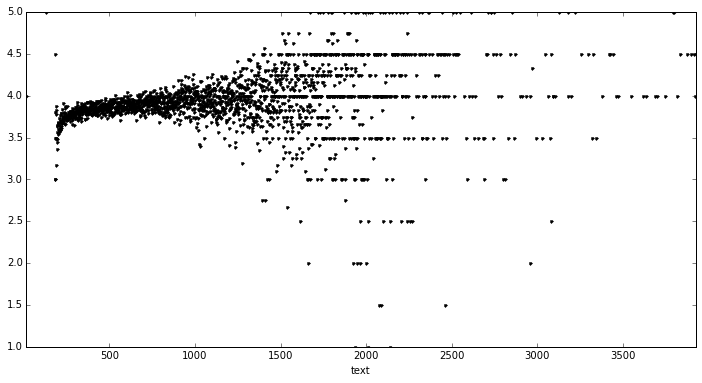

In [30]:
# %load -r 18:20 solutions_groupby.py
# Review by words
df.groupby(df.text.str.count('\w')).review_overall.mean().plot(style='k.')

In [ ]:
# %load -r 21:26 solutions_groupby.py
# Review by sentences.
(df.groupby(df.text.str.count('[. |! |\? |; ]'))
    .review_overall
    .mean()
    .plot(style='k.'))

In [32]:
# Your code goes here

### Exercise: Which **brewer** (`brewer_id`) has the largest gap between the min and max `review_overall` for two of their beers.

Hint: You'll need to do this in two steps.

1. Find the average `review_overall` by brewer and beername.
2. Find the difference between the max and min by brewer (rembember `.groupby(level=)`)

In [33]:
# Your code goes here. You've got this!

In [ ]:
# %load -r 6:13 solutions_groupby.py
# min-max gap
avg = (df.groupby(['brewer_id', 'beer_name'])
       .review_overall
       .mean())
extrema = avg.groupby(level='brewer_id').agg(['min', 'max'])
difference = extrema['max'] - extrema['min']
difference.order(ascending=False)

In [35]:
# Show for those with counts > 20ish

Create our own "kind" of beer, which aggregates `style`.

In [36]:
style = df.beer_style.str.lower()
style.head()

0                    american stout
1                   american porter
2                   german pilsener
3    american double / imperial ipa
4           american pale ale (apa)
Name: beer_style, dtype: object

In [37]:
kinds = ['ipa', 'apa', 'amber ale', 'rye', 'scotch', 'stout', 'barleywine', 'porter', 'brown ale', 'lager', 'pilsner',
         'tripel', 'biter', 'farmhouse', 'malt liquour', 'rice']

In [38]:
expr = '|'.join(['(?P<{name}>{pat})'.format(pat=kind, name=kind.replace(' ', '_')) for kind in kinds])
expr

'(?P<ipa>ipa)|(?P<apa>apa)|(?P<amber_ale>amber ale)|(?P<rye>rye)|(?P<scotch>scotch)|(?P<stout>stout)|(?P<barleywine>barleywine)|(?P<porter>porter)|(?P<brown_ale>brown ale)|(?P<lager>lager)|(?P<pilsner>pilsner)|(?P<tripel>tripel)|(?P<biter>biter)|(?P<farmhouse>farmhouse)|(?P<malt_liquour>malt liquour)|(?P<rice>rice)'

In [39]:
beer_kind = (style.replace({'india pale ale': 'ipa',
                            'american pale ale': 'apa'})
            .str.extract(expr).fillna('').sum(1)
            .str.lower().replace('', 'other'))
beer_kind.head()

0     stout
1    porter
2     other
3       ipa
4       apa
dtype: object

In [40]:
df.groupby(['brewer_id', beer_kind]).review_overall.mean()

brewer_id           
1          other        3.943662
3          apa          3.347826
           brown ale    3.582418
           ipa          3.662791
           lager        3.772727
                          ...   
23980      porter       3.681818
24926      other        4.166667
24964      other        3.600000
25680      lager        3.500000
27039      ipa          4.875000
Name: review_overall, dtype: float64

In [41]:
df.groupby(['brewer_id', beer_kind]).beer_id.nunique().unstack(1).fillna(0)

,apa,barleywine,brown ale,farmhouse,ipa,lager,other,pilsner,porter,rye,scotch,stout,tripel
brewer_id,,,,,,,,,,,,,
1,0,0,0,0,0,0,3,0,0,0,0,0,0
3,1,0,3,0,2,4,11,0,0,0,0,1,0
4,0,0,0,1,1,0,18,0,0,0,1,0,2
6,0,0,0,0,0,0,3,0,0,0,0,0,1
8,2,1,0,0,3,0,8,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23980,1,0,0,0,0,4,2,0,1,0,0,0,0
24926,0,0,0,0,0,0,3,0,0,0,0,0,0
24964,0,0,0,0,0,0,1,0,0,0,0,0,0


### Exercise: Which Brewers have the most different `kinds` of beer?

Hint: we used `df.profile_name.nunique()` to find the number of different profile names.
What are we grouping, and what is our grouper?

In [42]:
# %load -r 27:29 solutions_groupby.py

### Exercise: Which kinds of beer have the most brewers?

In [ ]:
# %load -r 30:32 solutions_groupby.py
# brewer per kind
df.brewer_id.groupby(beer_kind).nunique()

We've seen a lot of permutations among number of groupers, number of columns to aggregate, and number of aggregators.
In fact, the `.agg`, which returns one row per group, is just one kind of way to combine the results. The three ways are

- `agg`: one row per results
- `transform`: identicaly shaped output as input
- `apply`: anything goes


# Transform

Combined Series / DataFrame is the same shape as the input. For example, say you want to standardize the reviews by subtracting the mean.

In [44]:
def de_mean(reviews):
    s = reviews - reviews.mean()
    return s

In [45]:
de_mean(df.review_overall)

0        0.63927
1        0.63927
2       -0.86073
3        0.13927
4        0.13927
          ...   
99995    0.63927
99996    0.13927
99997   -1.36073
99998    0.13927
99999    0.63927
Name: review_overall, dtype: float64

We can do this at the *person* level with `groupby` and `transform`.

In [46]:
df.groupby('profile_name').transform(de_mean)

,abv,beer_id,brewer_id,review_appearance,review_aroma,review_overall,review_palate,review_taste
0,-2.763000,-14386.800000,-250.800000,0.350000,-0.050000,0.500000,-0.100000,0.450000
1,-1.622833,-8941.000000,4594.447761,0.462687,0.082090,0.395522,0.044776,-0.014925
2,-2.420000,-11859.162500,450.287500,0.025000,-0.968750,-0.875000,-0.631250,-0.350000
3,1.673333,-6783.687500,-1250.687500,0.250000,0.281250,0.093750,0.375000,0.312500
4,-1.996861,-25015.457746,-2934.570423,0.242958,-0.774648,0.295775,-0.242958,-0.683099
...,...,...,...,...,...,...,...,...
99995,-0.536528,-12955.893333,2269.973333,0.040000,0.580000,0.466667,0.520000,0.520000
99996,0.118182,-8688.272727,-3685.636364,0.090909,0.045455,0.090909,-0.181818,0.090909
99997,-0.500000,-822.000000,-201.500000,0.375000,-0.500000,-1.250000,0.250000,-0.375000
99998,-0.060876,-40408.033766,-6994.153247,-0.720779,0.331169,0.410390,-0.049351,0.468831


# Apply

So there's `gr.agg`. and `gr.transform`, and finally `gr.apply`. We're going to skip apply for now. I have an example in a later notebook. 

# Resample

Resample is a special kind of groupby operation for when you have a `DatetimeIndex`.

In [32]:
review_times = df.time.value_counts().sort_index()
review_times

2009-10-05 21:31:48    1
2009-10-05 21:32:09    1
2009-10-05 21:32:13    1
2009-10-05 21:32:37    1
2009-10-05 21:33:14    1
                      ..
2010-03-07 01:29:31    1
2010-03-07 01:30:35    1
2010-03-07 01:32:46    1
2010-03-07 01:33:29    1
2010-03-07 01:34:05    1
dtype: int64

In [33]:
review_times.index

DatetimeIndex(['2009-10-05 21:31:48', '2009-10-05 21:32:09',
               '2009-10-05 21:32:13', '2009-10-05 21:32:37',
               '2009-10-05 21:33:14', '2009-10-05 21:33:48',
               '2009-10-05 21:34:24', '2009-10-05 21:34:29',
               '2009-10-05 21:34:31', '2009-10-05 21:35:09', 
               ...
               '2010-03-07 01:22:40', '2010-03-07 01:25:09',
               '2010-03-07 01:25:50', '2010-03-07 01:27:21',
               '2010-03-07 01:28:05', '2010-03-07 01:29:31',
               '2010-03-07 01:30:35', '2010-03-07 01:32:46',
               '2010-03-07 01:33:29', '2010-03-07 01:34:05'],
              dtype='datetime64[ns]', length=99307, freq=None, tz=None)

The number of reviews within a given second isn't that interesting.

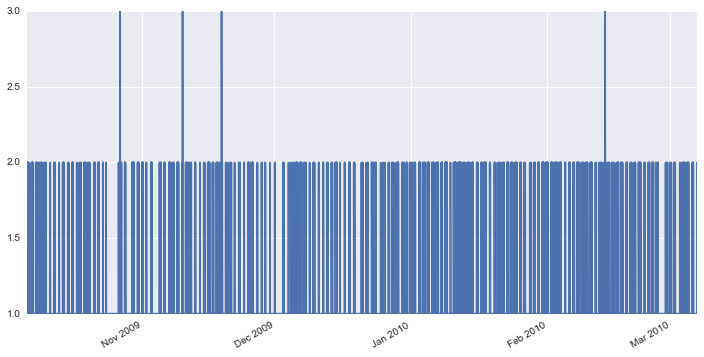

In [34]:
review_times.plot()

Right now the frequency is way to high to be meaningful. `resample` lets you adjust the frequency.

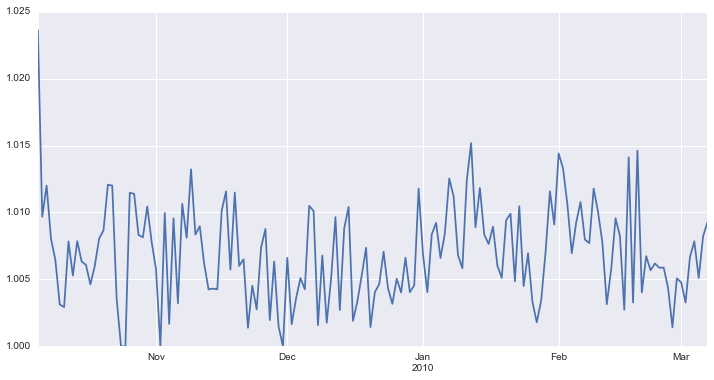

In [35]:
review_times.resample("D").plot()

We've essentially grouped by day here (but syntax of `.resample('d')` is much nicer than what we'd have to do to use the `.groupby(grouper)` spelling). By default the aggregation function is `mean`, i.e. take the average of all the values that fall on that day. You can also sum.

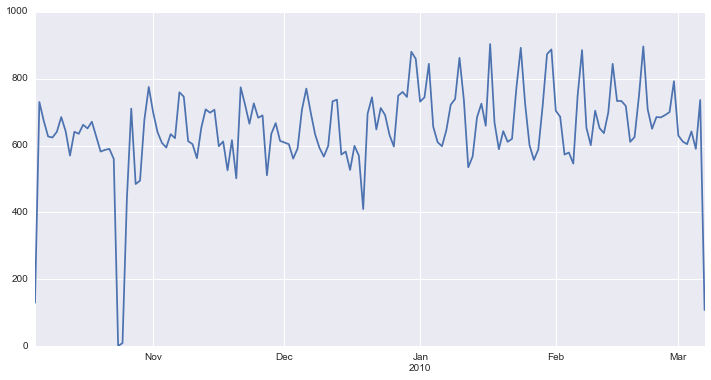

In [36]:
review_times.resample('D', how='sum').plot()

The `freq` you pass in to `resample` is pretty flexible.

In [37]:
review_times.resample('5D', how='sum')

2009-10-05 21:31:48    3326
2009-10-10 21:31:48    3172
2009-10-15 21:31:48    3203
2009-10-20 21:31:48    1838
2009-10-25 21:31:48    2697
                       ... 
2010-02-12 21:31:48    3736
2010-02-17 21:31:48    3577
2010-02-22 21:31:48    3402
2010-02-27 21:31:48    3292
2010-03-04 21:31:48    1529
Freq: 5D, dtype: int64

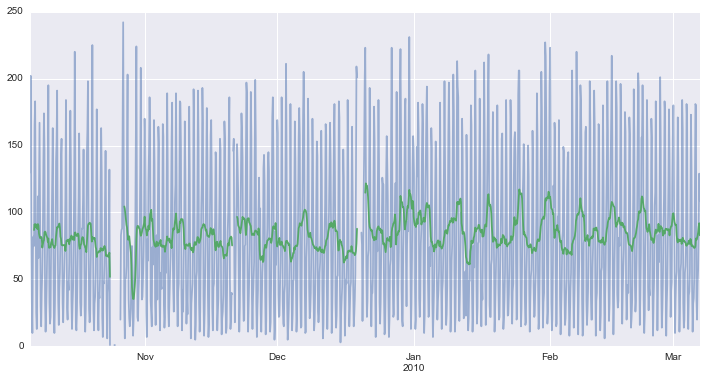

In [38]:
c = review_times.resample('3H', how='sum')
ax = c.plot(alpha=.5)
pd.rolling_mean(c, window=8).plot(ax=ax)


### Exercise: Plot the number of distinct brewers reviewed per day

- Hint: The documentation for `resample` is being worked on, but the `how` in `.resample` is *really* flexible. Try the first thing that comes to mind. What function do you want to apply to get the number of unique values?
- Hint2: (Sorry this is harder than I thought). `resample` needs a `DatetimeIndex`. We have datetimes in `time`. If only there was a way to take a column and **set** it as the **index**...

In [ ]:
%load -r 33:36 solutions_groupby.py

# Aside: Beer Recommender

See [Harvard CS109](https://github.com/cs109/content) for a more complete example (with chocolate instead of beer).

One place where transform comes in handy is as a preprocessing step for any kind of recommender. In some sense, raw score I assign a beer is less important the the score relative to *my* mean.

In [40]:
deduped = df[['beer_id', 'profile_name', 'review_overall']].drop_duplicates()
deduped.head()

,beer_id,profile_name,review_overall
0,2511,blaheath,4.5
1,19736,GJ40,4.5
2,11098,biegaman,3.0
3,28577,nick76,4.0
4,398,champ103,4.0


In [41]:
user_counts = deduped.profile_name.value_counts()
top_users = user_counts[user_counts > user_counts.quantile(.75)].index

In [42]:
beer_counts = deduped.beer_id.value_counts()
top_beers = beer_counts[beer_counts > beer_counts.quantile(.9)].index

In [43]:
top = deduped.query('beer_id in @top_beers and profile_name in @top_users')
user_means = top.groupby('profile_name').review_overall.mean()
beer_means = top.groupby('beer_id').review_overall.mean()


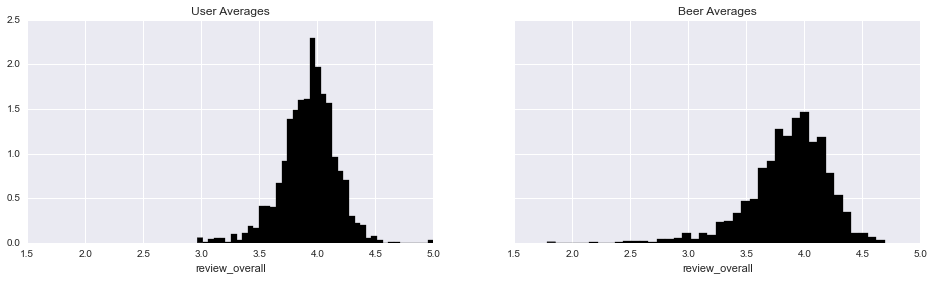

In [44]:
fig, axes = plt.subplots(figsize=(16, 4), ncols=2, sharey=True, sharex=True)

sns.distplot(user_means, kde=False, ax=axes[0], color='k', norm_hist=True, hist_kws={'alpha': 1})
sns.distplot(beer_means, kde=False, ax=axes[1], color='k', norm_hist=True, hist_kws={'alpha': 1})
axes[0].set_title("User Averages")
axes[1].set_title("Beer Averages")

In [45]:
s = top.set_index(['beer_id', 'profile_name']).review_overall.sort_index()
s.head()

beer_id  profile_name  
5        Ek0nomik          3.0
         HalfFull          4.5
         Jesstyr           4.0
         JordonHoltzman    4.0
         KTCamm            4.0
Name: review_overall, dtype: float64

###  `de_mean` the scores in `s`

In [46]:
standardized = s.groupby(level='profile_name').transform(de_mean)
standardized.head()

beer_id  profile_name  
5        Ek0nomik         -0.857143
         HalfFull          0.789474
         Jesstyr           0.233333
         JordonHoltzman    0.222222
         KTCamm            0.166667
Name: review_overall, dtype: float64

In [47]:
from scipy.stats import pearsonr

In [48]:
def pearson_sim(reviews_1, reviews_2, reg=2):
    """
    (regularized) Pearson correlation coefficient between sets
    of reviews for two beers, made by a common subset
    of reviewers.
    
    `reviews_1` and `reviews_2` should be have the same index,
    the `profile_name`s of people who reviewed both beers.
    """
    n_common = len(reviews_1)
    if n_common == 0:
        similarity = 0
    else:
        rho = pearsonr(reviews_1, reviews_2)[0]
        similarity = (n_common * rho) / (n_common + reg)  # regularization if few reviews
    return similarity, n_common

In [49]:
def beer_similarity(standardized, beer_1, beer_2, simfunc=pearson_sim, **simfunc_kwargs):
    """
    Compute the similarity between two beers.
    """
    # get common subset...
    reviewers_1 = standardized.loc[beer_1].index
    reviewers_2 = standardized.loc[beer_2].index
    common_idx = reviewers_1 & reviewers_2  # set intersection

    # slice the Multiindex, unstack to be N x 2
    common_reviews = standardized.loc[[beer_1, beer_2], common_idx].unstack('beer_id')
    # ... review similairty for subset
    rho, n_common = simfunc(common_reviews[beer_1], common_reviews[beer_2], **simfunc_kwargs)
    return rho, n_common

In [50]:
beer_ids = s.index.levels[0]
len(beer_ids)

1266

In [51]:
beer_similarity(standardized, beer_ids[0], beer_ids[10])

(0.58989530654977695, 3)

In [509]:
%%time
sims = []

for i, beer_1 in enumerate(beer_ids):
    for j, beer_2 in enumerate(beer_ids):
        if j >= i:
            continue
        sim, n_common = beer_similarity(s, beer_1, beer_2)
        sims.append((beer_1, beer_2, sim, n_common))
        print((i, j), end='\r')
        
sim = pd.DataFrame(sims, columns=['beer_1', 'beer_2', 'score', 'n_common'])
sim.to_csv('beer_subset_similarity.csv', index=False)

CPU times: user 51min 33s, sys: 50.4 s, total: 52min 24s
Wall time: 53min 7s


In [53]:
sim = pd.read_csv('beer_subset_similarity.csv.gz')
sim.head()

,beer_1,beer_2,score,n_common
0,6,5,0.306201,11
1,7,5,0.385503,6
2,7,6,0.553703,8
3,10,5,0.500000,2
4,10,6,NaN,1


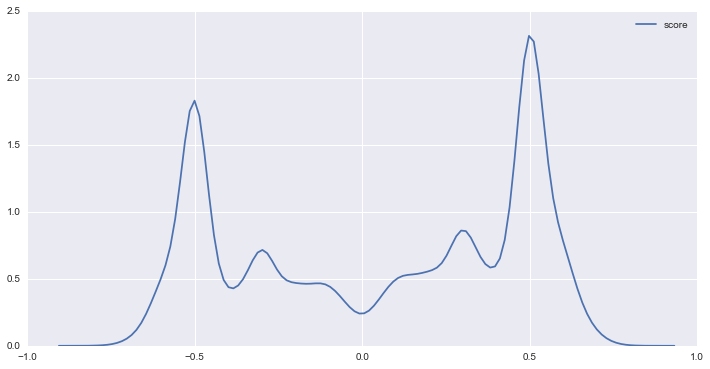

In [61]:
sns.kdeplot(sim[sim.score != 0].dropna().score)

In [62]:
sim = sim.set_index(['beer_1', 'beer_2']).score

In [63]:
sim.loc[21690].nlargest(5)

beer_2
1632     0.684993
2948     0.666667
5441     0.666667
16520    0.656113
1445     0.618115
Name: score, dtype: float64